In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
from torchvision.datasets import DatasetFolder
import numpy as np
import time
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
# need to install 
import seaborn as sns

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(135)

In [3]:
class NeuroNetwork(nn.Module):
    def __init__(self):
        super(NeuroNetwork, self).__init__()
        first_layer = 64
        second_layer = 128
        third_layer = 256
        forth_layer = 512
        fc_layer = 1024
        output = 25
        self.cnn_layers = nn.Sequential(
            # First layer
            nn.Conv2d(in_channels=3,  # RGB 3 layer3
                      out_channels=first_layer,  # Output layer -- the number of filters
                      kernel_size=3,  # Size of filter --3*3
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(first_layer),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Second layer
            nn.Conv2d(first_layer, second_layer, 3, 1, 1),
            nn.BatchNorm2d(second_layer),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Third layer
            nn.Conv2d(second_layer, third_layer, 3, 1, 1),
            nn.BatchNorm2d(third_layer),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Forth layer
            nn.Conv2d(third_layer, forth_layer, 3, 1, 1),
            nn.BatchNorm2d(forth_layer),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(forth_layer * 8 * 8, fc_layer),
            nn.BatchNorm1d(fc_layer),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fc_layer, output)
        )

    def forward(self, x):
        x = self.cnn_layers(x)

        x = x.flatten(1)
        visual_item = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x, visual_item

In [4]:
train_tfm = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomRotation(degrees=25),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Data
train_set = DatasetFolder("dataset/arcDataset", loader=lambda x: Image.open(x).convert("RGB"), extensions="jpg",
                          transform=train_tfm)
test_set = DatasetFolder("dataset/arcValidset", loader=lambda x: Image.open(x).convert("RGB"), extensions="jpg",
                         transform=test_tfm)

In [5]:
# Batch size of 128
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

device = "cuda" if torch.cuda.is_available() else "cpu"

# CrossEntropy loss are applied
cross_entropy = nn.CrossEntropyLoss()

cnn = NeuroNetwork().to(device)
cnn.device = device
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)

train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []

In [6]:
def save_model():
    checkpoint = {
        "net": cnn.state_dict(),
        'optimizer': optimizer.state_dict(),
        "epoch": epoch
    }

    fomat_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

    torch.save(checkpoint, 'models/checkpoint/autosave_' + fomat_time)


def plot_with_labels(lowDWeights, labels):
    # plt.cla()
    # fig, ax = plt.subplots()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    labels = np.ravel(labels)
    classes = list(np.unique(labels))
    markers = 'os' * len(classes)
    colors = sns.color_palette("husl",len(classes))
    # colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    for x, y, s in zip(X, Y, labels):
        i = int(s)
        # plt.text(x, y, s, backgroundcolor=colors[i], fontsize=8)
        plt.scatter(x, y, marker=markers[i], c=[colors[i]], alpha=0.6)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title('Visualize last layer')

    plt.legend()
    plt.axis("off")
    # fig.set_facecolor('k')
    plt.show()

In [ ]:
x = np.arange(len(train_acc_record))
plt.plot(x, train_acc_record, color="blue", label="Train")
plt.plot(x, valid_acc_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()

x = np.arange(len(train_loss_record))
plt.plot(x, train_loss_record, color="blue", label="Train")
plt.plot(x, valid_loss_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()


Epoch:  0
[ Train | 001/150 ] loss = 2.64559, acc = 0.22160
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

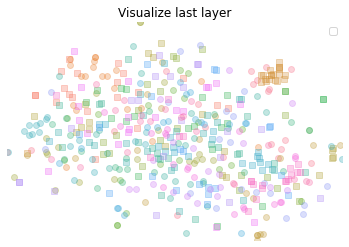

[ Test | 001/150 ] loss = 2.62661, acc = 0.23572
[Time cost | 001/150]: 1001.0556s
Epoch:  1
[ Train | 002/150 ] loss = 2.19046, acc = 0.33082
squeezing data
visualizing


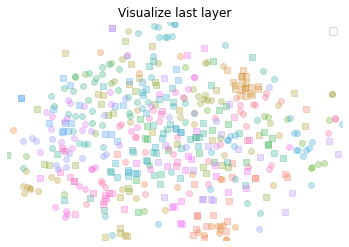

[ Test | 002/150 ] loss = 2.27059, acc = 0.32146
[Time cost | 002/150]: 1514.4937s
Epoch:  2
[ Train | 003/150 ] loss = 1.97381, acc = 0.38828
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

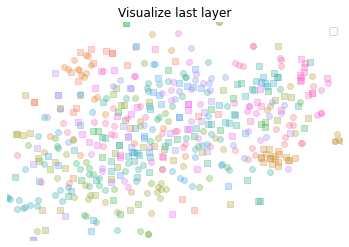

[ Test | 003/150 ] loss = 2.95217, acc = 0.22932
[Time cost | 003/150]: 920.6554s
Epoch:  3
[ Train | 004/150 ] loss = 1.81311, acc = 0.43846
squeezing data
visualizing


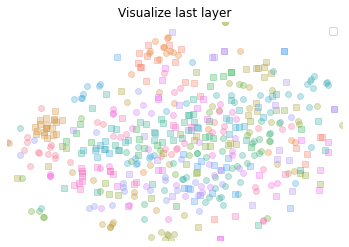

[ Test | 004/150 ] loss = 2.66428, acc = 0.29182
[Time cost | 004/150]: 972.9208s
Epoch:  4
[ Train | 005/150 ] loss = 1.68156, acc = 0.47628
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

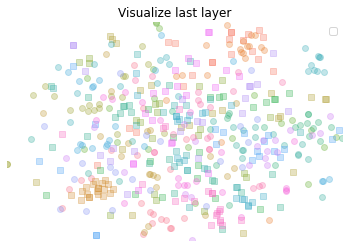

[ Test | 005/150 ] loss = 2.38353, acc = 0.33762
[Time cost | 005/150]: 1041.7977s
Epoch:  5
[ Train | 006/150 ] loss = 1.58544, acc = 0.50833
squeezing data
visualizing


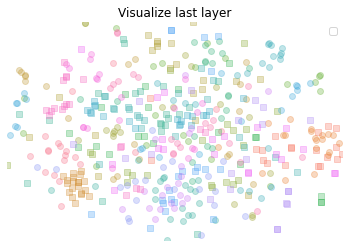

[ Test | 006/150 ] loss = 2.14612, acc = 0.37668
[Time cost | 006/150]: 868.7654s
Epoch:  6
[ Train | 007/150 ] loss = 1.49446, acc = 0.52975
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

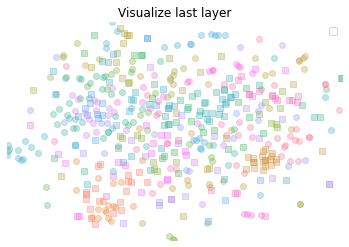

[ Test | 007/150 ] loss = 2.15571, acc = 0.38564
[Time cost | 007/150]: 954.7839s
Epoch:  7
[ Train | 008/150 ] loss = 1.41291, acc = 0.55073
squeezing data
visualizing


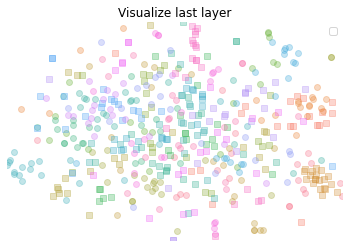

[ Test | 008/150 ] loss = 1.95562, acc = 0.43629
[Time cost | 008/150]: 907.2478s
Epoch:  8
[ Train | 009/150 ] loss = 1.30748, acc = 0.58840
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

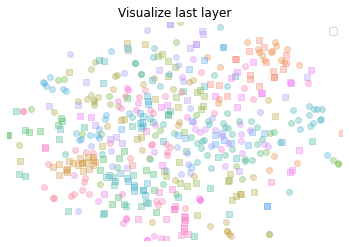

[ Test | 009/150 ] loss = 1.89220, acc = 0.45057
[Time cost | 009/150]: 958.2948s
Epoch:  9
[ Train | 010/150 ] loss = 1.24923, acc = 0.60586
squeezing data
visualizing


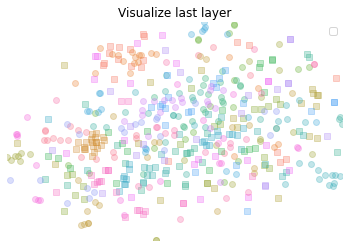

[ Test | 010/150 ] loss = 1.97459, acc = 0.43939
[Time cost | 010/150]: 1101.9422s
Epoch:  10
[ Train | 011/150 ] loss = 1.17780, acc = 0.62317
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

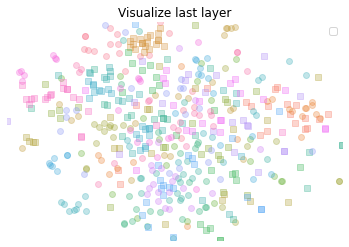

[ Test | 011/150 ] loss = 1.98006, acc = 0.42470
[Time cost | 011/150]: 858.6695s
Epoch:  11
[ Train | 012/150 ] loss = 1.11014, acc = 0.64523
squeezing data
visualizing


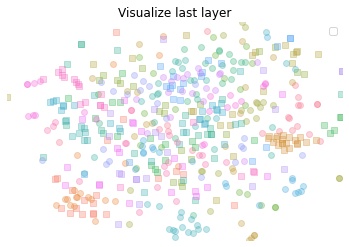

[ Test | 012/150 ] loss = 2.14479, acc = 0.42652
[Time cost | 012/150]: 1170.6826s
Epoch:  12
[ Train | 013/150 ] loss = 1.03754, acc = 0.66961
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

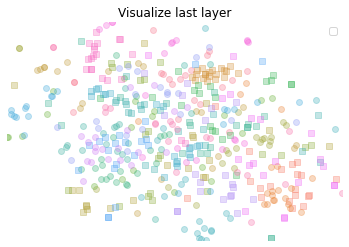

[ Test | 013/150 ] loss = 1.99140, acc = 0.43427
[Time cost | 013/150]: 1005.5586s
Epoch:  13
[ Train | 014/150 ] loss = 0.98537, acc = 0.68427
squeezing data
visualizing


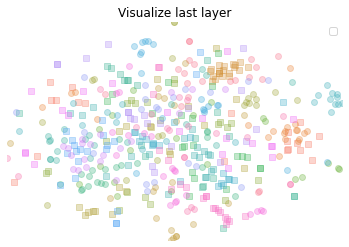

[ Test | 014/150 ] loss = 1.94744, acc = 0.40874
[Time cost | 014/150]: 984.6367s
Epoch:  14
[ Train | 015/150 ] loss = 0.92206, acc = 0.70392
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

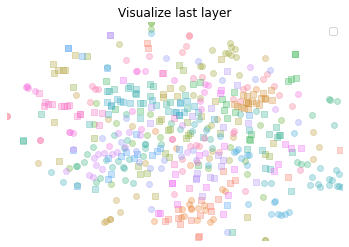

[ Test | 015/150 ] loss = 1.87318, acc = 0.47124
[Time cost | 015/150]: 950.2476s
Epoch:  15
[ Train | 016/150 ] loss = 0.86903, acc = 0.72445
squeezing data
visualizing


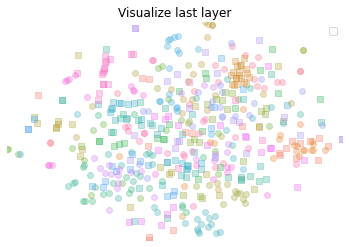

[ Test | 016/150 ] loss = 1.92525, acc = 0.47165
[Time cost | 016/150]: 1041.7227s
Epoch:  16
[ Train | 017/150 ] loss = 0.79131, acc = 0.74983
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

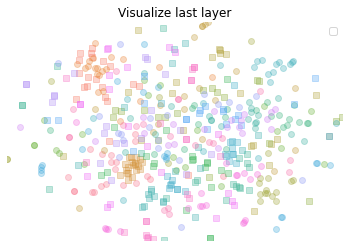

[ Test | 017/150 ] loss = 2.17223, acc = 0.44531
[Time cost | 017/150]: 977.8124s
Epoch:  17
[ Train | 018/150 ] loss = 0.75041, acc = 0.76309
squeezing data
visualizing


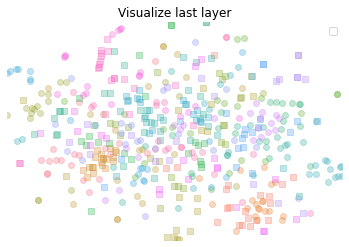

[ Test | 018/150 ] loss = 1.94982, acc = 0.50391
[Time cost | 018/150]: 1023.0403s
Epoch:  18
[ Train | 019/150 ] loss = 0.68826, acc = 0.77764
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

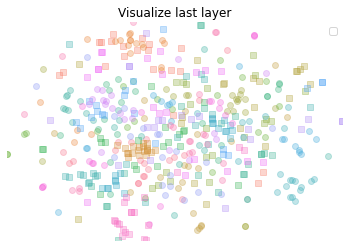

[ Test | 019/150 ] loss = 2.03265, acc = 0.48182
[Time cost | 019/150]: 984.4523s
Epoch:  19
[ Train | 020/150 ] loss = 0.64796, acc = 0.78971
squeezing data
visualizing


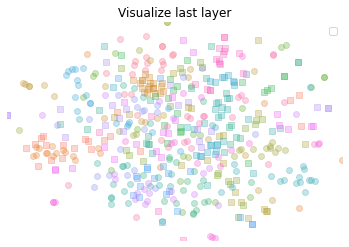

[ Test | 020/150 ] loss = 2.01073, acc = 0.49273
[Time cost | 020/150]: 1070.2774s
Epoch:  20
[ Train | 021/150 ] loss = 0.59979, acc = 0.80760
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

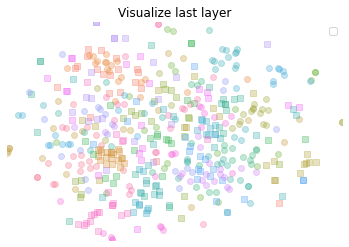

[ Test | 021/150 ] loss = 2.27553, acc = 0.46969
[Time cost | 021/150]: 1014.9284s
Epoch:  21
[ Train | 022/150 ] loss = 0.57457, acc = 0.81597
squeezing data
visualizing


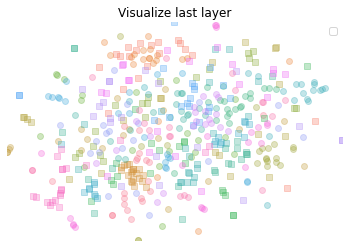

[ Test | 022/150 ] loss = 2.20797, acc = 0.46437
[Time cost | 022/150]: 1199.7688s
Epoch:  22
[ Train | 023/150 ] loss = 0.57782, acc = 0.81713
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

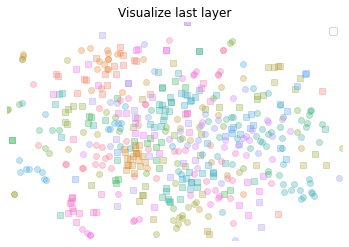

[ Test | 023/150 ] loss = 2.05295, acc = 0.48296
[Time cost | 023/150]: 1182.0507s
Epoch:  23
[ Train | 024/150 ] loss = 0.53646, acc = 0.82888
squeezing data
visualizing


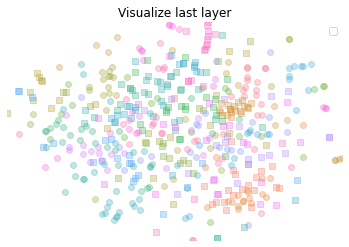

[ Test | 024/150 ] loss = 1.98735, acc = 0.48976
[Time cost | 024/150]: 957.8135s
Epoch:  24
[ Train | 025/150 ] loss = 0.45971, acc = 0.85625
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

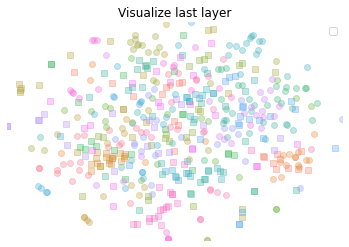

[ Test | 025/150 ] loss = 2.08892, acc = 0.50546
[Time cost | 025/150]: 951.6057s
Epoch:  25
[ Train | 026/150 ] loss = 0.47010, acc = 0.85394
squeezing data
visualizing


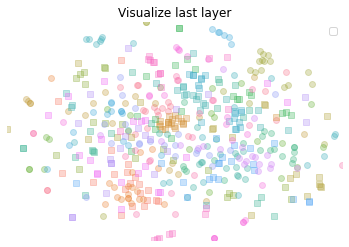

[ Test | 026/150 ] loss = 2.17511, acc = 0.51583
[Time cost | 026/150]: 862.6099s
Epoch:  26
[ Train | 027/150 ] loss = 0.41104, acc = 0.87299
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

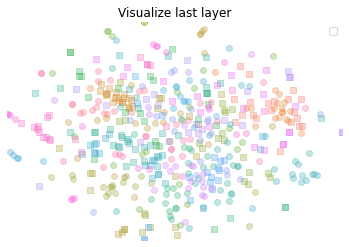

[ Test | 027/150 ] loss = 2.20734, acc = 0.48532
[Time cost | 027/150]: 976.2826s
Epoch:  27
[ Train | 028/150 ] loss = 0.39279, acc = 0.87789
squeezing data
visualizing


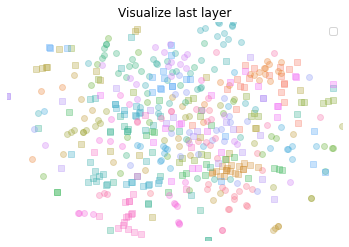

[ Test | 028/150 ] loss = 2.21434, acc = 0.47394
[Time cost | 028/150]: 932.1477s
Epoch:  28
[ Train | 029/150 ] loss = 0.35688, acc = 0.89173
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

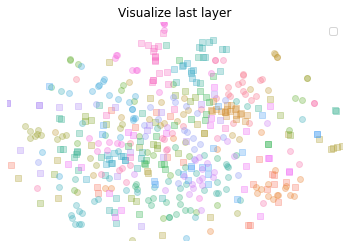

[ Test | 029/150 ] loss = 2.37878, acc = 0.47777
[Time cost | 029/150]: 875.9717s
Epoch:  29
[ Train | 030/150 ] loss = 0.38535, acc = 0.87608
squeezing data
visualizing


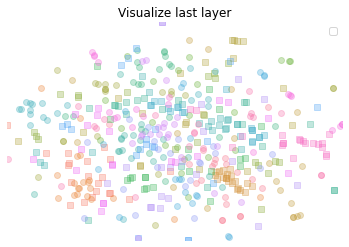

[ Test | 030/150 ] loss = 2.12970, acc = 0.52128
[Time cost | 030/150]: 1026.0987s
Epoch:  30
[ Train | 031/150 ] loss = 0.36248, acc = 0.88420
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

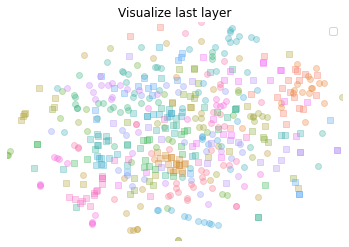

[ Test | 031/150 ] loss = 2.12194, acc = 0.52324
[Time cost | 031/150]: 892.3488s
Epoch:  31
[ Train | 032/150 ] loss = 0.32950, acc = 0.89932
squeezing data
visualizing


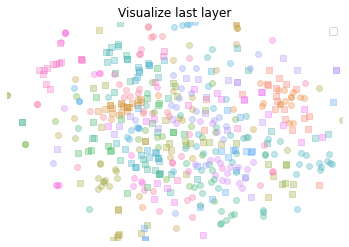

[ Test | 032/150 ] loss = 2.43699, acc = 0.49333
[Time cost | 032/150]: 1010.5466s
Epoch:  32
[ Train | 033/150 ] loss = 0.33745, acc = 0.89179
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

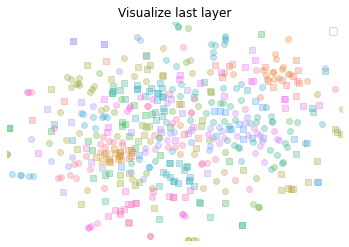

[ Test | 033/150 ] loss = 2.26090, acc = 0.51758
[Time cost | 033/150]: 1023.2410s
Epoch:  33
[ Train | 034/150 ] loss = 0.30015, acc = 0.90238
squeezing data
visualizing


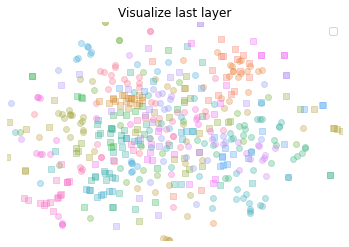

[ Test | 034/150 ] loss = 2.18097, acc = 0.50977
[Time cost | 034/150]: 922.2865s
Epoch:  34
[ Train | 035/150 ] loss = 0.29126, acc = 0.91051
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

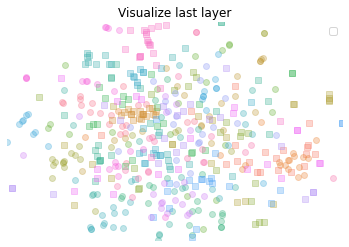

[ Test | 035/150 ] loss = 2.40740, acc = 0.47178
[Time cost | 035/150]: 1157.8140s
Epoch:  35
[ Train | 036/150 ] loss = 0.29318, acc = 0.90687
squeezing data
visualizing


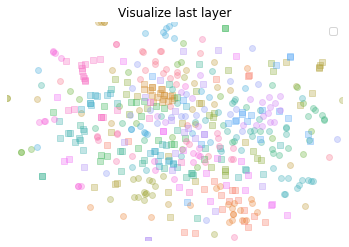

[ Test | 036/150 ] loss = 2.26557, acc = 0.48633
[Time cost | 036/150]: 1146.5275s
Epoch:  36
[ Train | 037/150 ] loss = 0.25266, acc = 0.92430
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

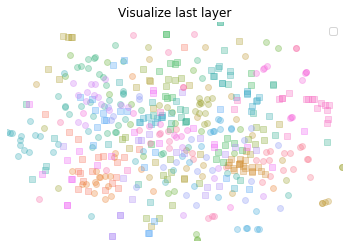

[ Test | 037/150 ] loss = 2.20232, acc = 0.52270
[Time cost | 037/150]: 937.1511s
Epoch:  37
[ Train | 038/150 ] loss = 0.26478, acc = 0.91731
squeezing data
visualizing


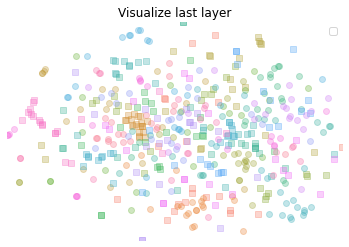

[ Test | 038/150 ] loss = 2.39077, acc = 0.50101
[Time cost | 038/150]: 1015.8078s
Epoch:  38
[ Train | 039/150 ] loss = 0.28234, acc = 0.90976
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

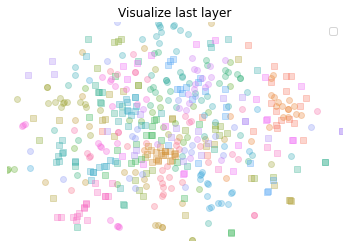

[ Test | 039/150 ] loss = 2.15166, acc = 0.52559
[Time cost | 039/150]: 1026.7238s
Epoch:  39
[ Train | 040/150 ] loss = 0.22007, acc = 0.92975
squeezing data
visualizing


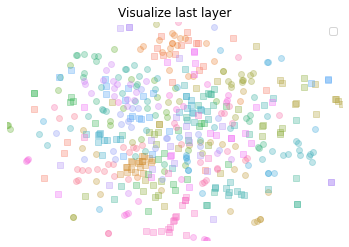

[ Test | 040/150 ] loss = 2.24422, acc = 0.52054
[Time cost | 040/150]: 1028.1841s
Epoch:  40
[ Train | 041/150 ] loss = 0.23667, acc = 0.92420
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

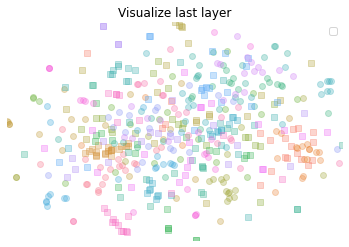

[ Test | 041/150 ] loss = 2.20548, acc = 0.52856
[Time cost | 041/150]: 1024.1368s
Epoch:  41
[ Train | 042/150 ] loss = 0.25630, acc = 0.92116
squeezing data
visualizing


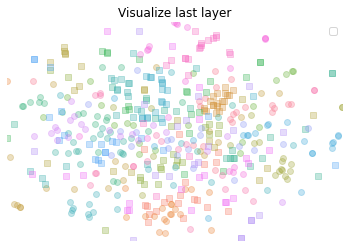

[ Test | 042/150 ] loss = 2.43915, acc = 0.51852
[Time cost | 042/150]: 1108.9567s
Epoch:  42
[ Train | 043/150 ] loss = 0.21064, acc = 0.93606
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

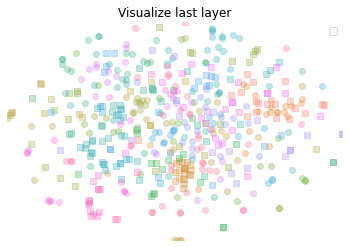

[ Test | 043/150 ] loss = 2.29078, acc = 0.51542
[Time cost | 043/150]: 1102.0120s
Epoch:  43
[ Train | 044/150 ] loss = 0.19388, acc = 0.93998
squeezing data
visualizing


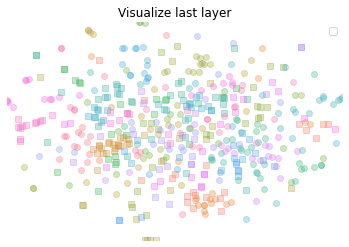

[ Test | 044/150 ] loss = 2.61395, acc = 0.49529
[Time cost | 044/150]: 1096.5472s
Epoch:  44
[ Train | 045/150 ] loss = 0.19108, acc = 0.94277
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

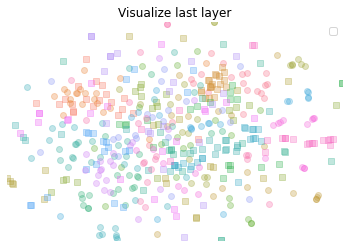

[ Test | 045/150 ] loss = 2.55500, acc = 0.48478
[Time cost | 045/150]: 837.8166s
Epoch:  45
[ Train | 046/150 ] loss = 0.25216, acc = 0.92002
squeezing data
visualizing


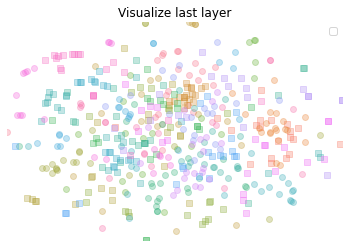

[ Test | 046/150 ] loss = 2.46336, acc = 0.50741
[Time cost | 046/150]: 810.6729s
Epoch:  46
[ Train | 047/150 ] loss = 0.17794, acc = 0.94562
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

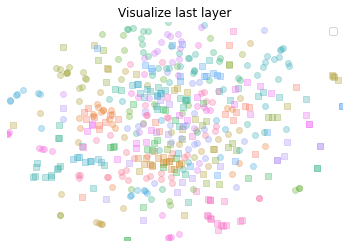

[ Test | 047/150 ] loss = 2.36581, acc = 0.52128
[Time cost | 047/150]: 851.5408s
Epoch:  47
[ Train | 048/150 ] loss = 0.16849, acc = 0.94727
squeezing data
visualizing


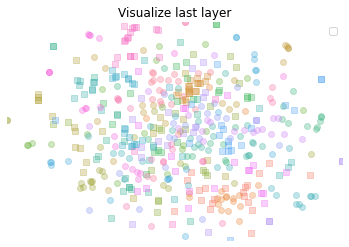

[ Test | 048/150 ] loss = 2.43736, acc = 0.50795
[Time cost | 048/150]: 800.0500s
Epoch:  48
[ Train | 049/150 ] loss = 0.17345, acc = 0.94678
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

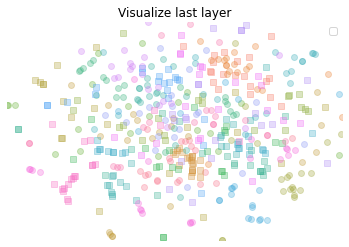

[ Test | 049/150 ] loss = 2.58558, acc = 0.52849
[Time cost | 049/150]: 835.4358s
Epoch:  49
[ Train | 050/150 ] loss = 0.21942, acc = 0.93064
squeezing data
visualizing


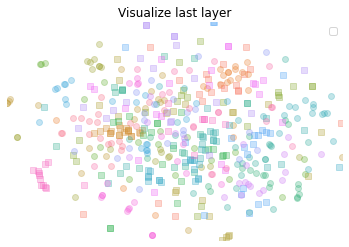

[ Test | 050/150 ] loss = 2.42392, acc = 0.52189
[Time cost | 050/150]: 1211.9781s
Epoch:  50
[ Train | 051/150 ] loss = 0.17615, acc = 0.94523
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

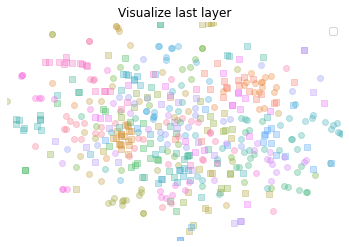

[ Test | 051/150 ] loss = 2.57533, acc = 0.50411
[Time cost | 051/150]: 1307.7024s
Epoch:  51
[ Train | 052/150 ] loss = 0.17005, acc = 0.94697
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


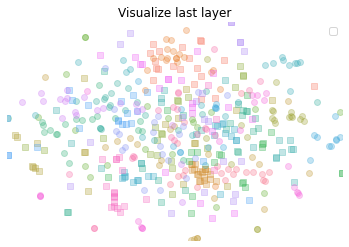

[ Test | 052/150 ] loss = 2.80436, acc = 0.51111
[Time cost | 052/150]: 1056.9397s
Epoch:  52
[ Train | 053/150 ] loss = 0.20099, acc = 0.93928
squeezing data
visualizing


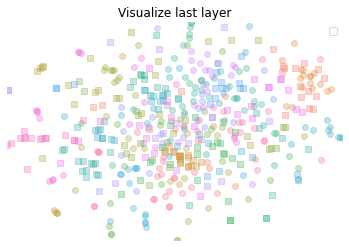

[ Test | 053/150 ] loss = 2.50626, acc = 0.50216
[Time cost | 053/150]: 1292.8417s
Epoch:  53
[ Train | 054/150 ] loss = 0.19883, acc = 0.93922
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

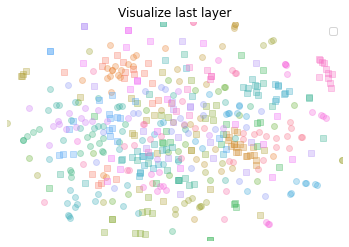

[ Test | 054/150 ] loss = 2.49773, acc = 0.48963
[Time cost | 054/150]: 833.7563s
Epoch:  54
[ Train | 055/150 ] loss = 0.22781, acc = 0.93239
squeezing data
visualizing


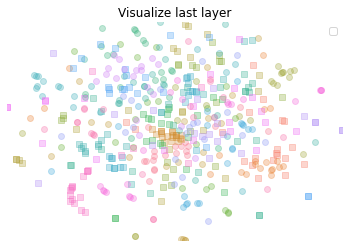

[ Test | 055/150 ] loss = 2.71554, acc = 0.50330
[Time cost | 055/150]: 846.9388s
Epoch:  55
[ Train | 056/150 ] loss = 0.18909, acc = 0.94356
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

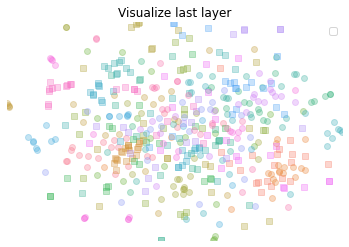

[ Test | 056/150 ] loss = 2.38596, acc = 0.53361
[Time cost | 056/150]: 809.5375s
Epoch:  56
[ Train | 057/150 ] loss = 0.17142, acc = 0.94855
squeezing data
visualizing


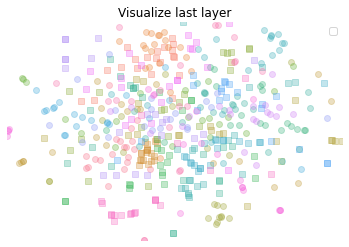

[ Test | 057/150 ] loss = 2.43785, acc = 0.51717
[Time cost | 057/150]: 820.5255s
Epoch:  57
[ Train | 058/150 ] loss = 0.18231, acc = 0.94361
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

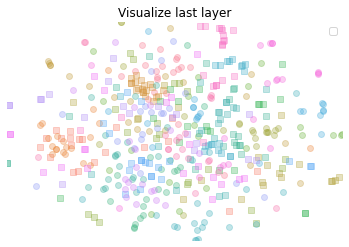

[ Test | 058/150 ] loss = 2.67089, acc = 0.50350
[Time cost | 058/150]: 926.4871s
Epoch:  58
[ Train | 059/150 ] loss = 0.17987, acc = 0.94380
squeezing data
visualizing


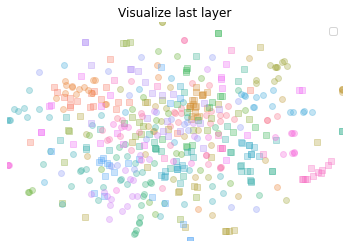

[ Test | 059/150 ] loss = 2.52309, acc = 0.51933
[Time cost | 059/150]: 1487.9819s
Epoch:  59
[ Train | 060/150 ] loss = 0.16192, acc = 0.95241
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

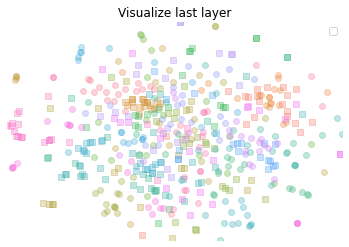

[ Test | 060/150 ] loss = 2.37549, acc = 0.54708
[Time cost | 060/150]: 1009.6446s
Epoch:  60
[ Train | 061/150 ] loss = 0.16056, acc = 0.95232
squeezing data
visualizing


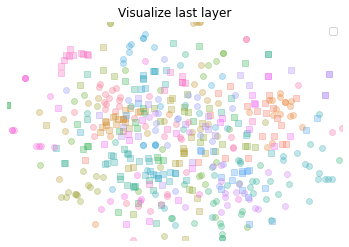

[ Test | 061/150 ] loss = 2.66718, acc = 0.50855
[Time cost | 061/150]: 1326.0263s
Epoch:  61
[ Train | 062/150 ] loss = 0.14208, acc = 0.95552
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

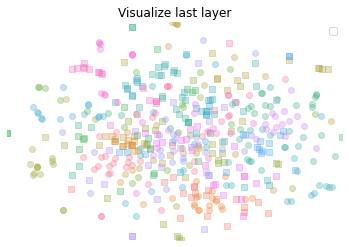

[ Test | 062/150 ] loss = 2.40867, acc = 0.53926
[Time cost | 062/150]: 1035.2584s
Epoch:  62
[ Train | 063/150 ] loss = 0.16387, acc = 0.94825
squeezing data
visualizing


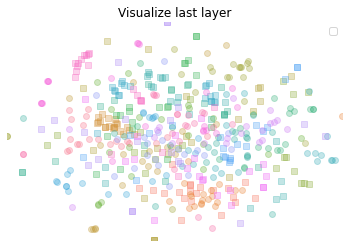

[ Test | 063/150 ] loss = 2.49446, acc = 0.53805
[Time cost | 063/150]: 1395.5371s
Epoch:  63
[ Train | 064/150 ] loss = 0.17401, acc = 0.94737
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

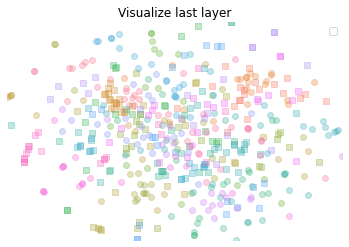

[ Test | 064/150 ] loss = 2.48649, acc = 0.55199
[Time cost | 064/150]: 904.4816s
Epoch:  64
[ Train | 065/150 ] loss = 0.13521, acc = 0.95931
squeezing data
visualizing


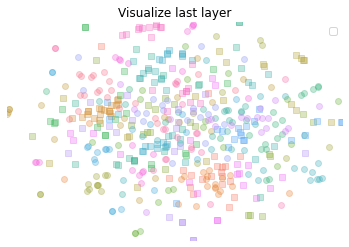

[ Test | 065/150 ] loss = 2.62025, acc = 0.50862
[Time cost | 065/150]: 1013.3545s
Epoch:  65


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

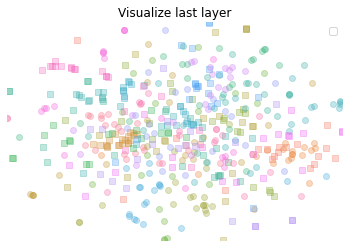

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


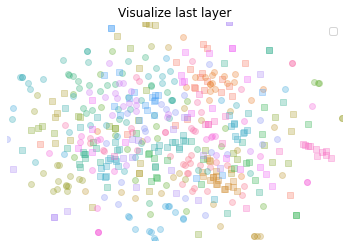

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


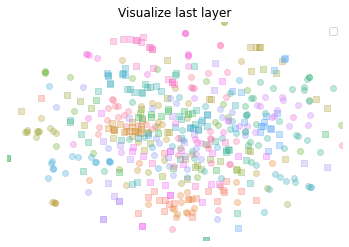

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


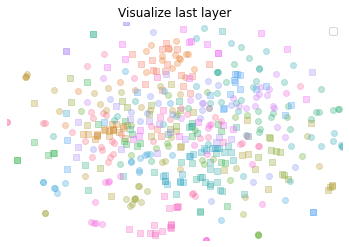

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


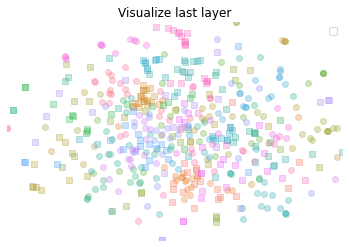

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


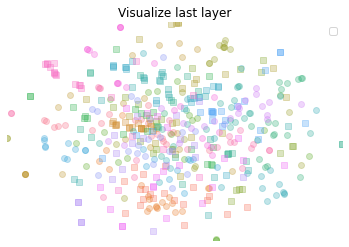

[ Train | 066/150 ] loss = 0.13486, acc = 0.96075
squeezing data
visualizing
[ Test | 066/150 ] loss = 2.70519, acc = 0.53637
[Time cost | 066/150]: 1386.8741s
Epoch:  66
[ Train | 067/150 ] loss = 0.12925, acc = 0.95982
squeezing data
visualizing
[ Test | 067/150 ] loss = 2.65266, acc = 0.52869
[Time cost | 067/150]: 1005.6018s
Epoch:  67
[ Train | 068/150 ] loss = 0.14911, acc = 0.95195
squeezing data
visualizing
[ Test | 068/150 ] loss = 2.65114, acc = 0.53805
[Time cost | 068/150]: 911.3024s
Epoch:  68
[ Train | 069/150 ] loss = 0.17450, acc = 0.94822
squeezing data
visualizing
[ Test | 069/150 ] loss = 2.71656, acc = 0.50512
[Time cost | 069/150]: 851.9202s
Epoch:  69
[ Train | 070/150 ] loss = 0.16660, acc = 0.94810
squeezing data
visualizing
[ Test | 070/150 ] loss = 2.65397, acc = 0.52324
[Time cost | 070/150]: 908.6972s
Epoch:  70
[ Train | 071/150 ] loss = 0.16362, acc = 0.95222
squeezing data
visualizing
[ Test | 071/150 ] loss = 2.81831, acc = 0.49044
[Time cost | 071/150]:

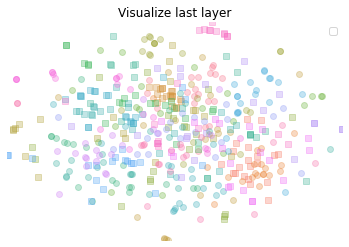

[ Test | 072/150 ] loss = 2.74857, acc = 0.50094
[Time cost | 072/150]: 939.7437s
Epoch:  72
[ Train | 073/150 ] loss = 0.12329, acc = 0.96371
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

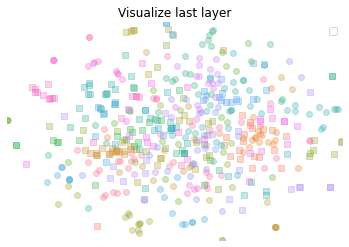

[ Test | 073/150 ] loss = 2.66011, acc = 0.50094
[Time cost | 073/150]: 1055.9710s
Epoch:  73
[ Train | 074/150 ] loss = 0.11223, acc = 0.96731
squeezing data
visualizing


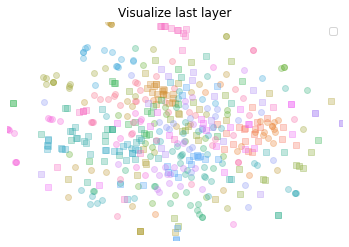

[ Test | 074/150 ] loss = 2.60896, acc = 0.54337
[Time cost | 074/150]: 1378.4552s
Epoch:  74
[ Train | 075/150 ] loss = 0.11397, acc = 0.96755
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

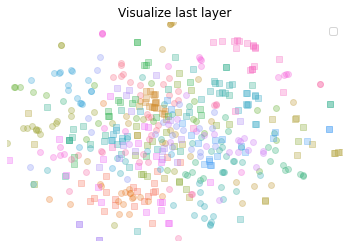

[ Test | 075/150 ] loss = 2.71475, acc = 0.54432
[Time cost | 075/150]: 1422.6163s
Epoch:  75
[ Train | 076/150 ] loss = 0.15157, acc = 0.95448
squeezing data
visualizing


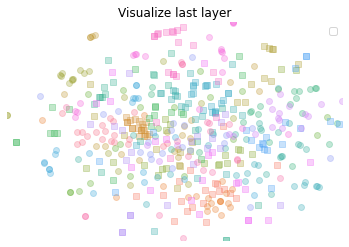

[ Test | 076/150 ] loss = 2.91036, acc = 0.49508
[Time cost | 076/150]: 1129.2108s
Epoch:  76
[ Train | 077/150 ] loss = 0.13196, acc = 0.95981
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

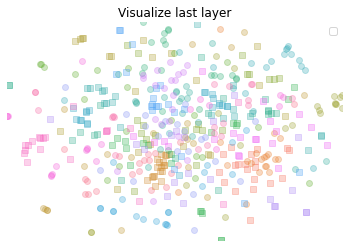

[ Test | 077/150 ] loss = 2.85684, acc = 0.51994
[Time cost | 077/150]: 1197.6310s
Epoch:  77
[ Train | 078/150 ] loss = 0.11045, acc = 0.96816
squeezing data
visualizing


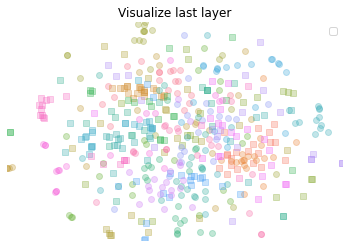

[ Test | 078/150 ] loss = 2.50808, acc = 0.52876
[Time cost | 078/150]: 936.8263s
Epoch:  78
[ Train | 079/150 ] loss = 0.13304, acc = 0.95878
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

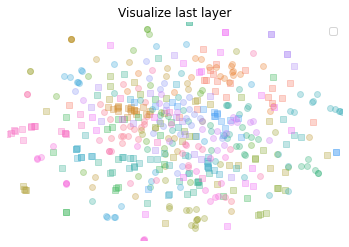

[ Test | 079/150 ] loss = 2.89048, acc = 0.52990
[Time cost | 079/150]: 1228.5984s
Epoch:  79
[ Train | 080/150 ] loss = 0.11842, acc = 0.96518
squeezing data
visualizing


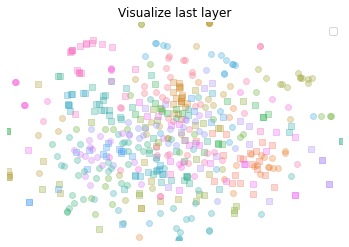

[ Test | 080/150 ] loss = 3.00404, acc = 0.50741
[Time cost | 080/150]: 1014.6336s
Epoch:  80
[ Train | 081/150 ] loss = 0.14700, acc = 0.95417
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

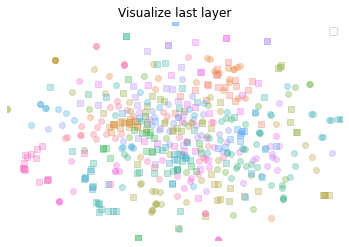

[ Test | 081/150 ] loss = 2.65390, acc = 0.53024
[Time cost | 081/150]: 1203.0850s
Epoch:  81
[ Train | 082/150 ] loss = 0.15169, acc = 0.95603
squeezing data
visualizing


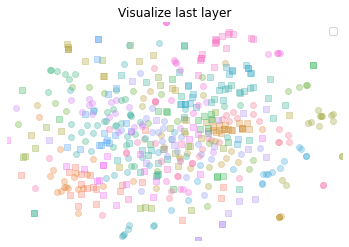

[ Test | 082/150 ] loss = 2.73492, acc = 0.52108
[Time cost | 082/150]: 920.6015s
Epoch:  82
[ Train | 083/150 ] loss = 0.17872, acc = 0.94452
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

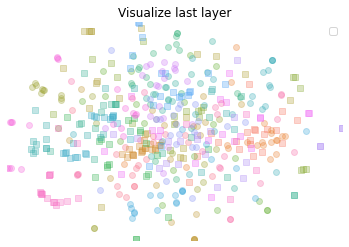

[ Test | 083/150 ] loss = 2.72081, acc = 0.51657
[Time cost | 083/150]: 1067.6157s
Epoch:  83
[ Train | 084/150 ] loss = 0.15116, acc = 0.95458
squeezing data
visualizing


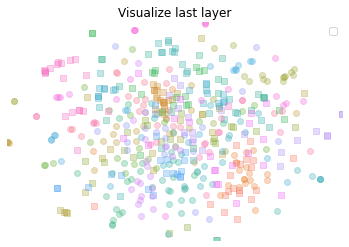

[ Test | 084/150 ] loss = 2.82052, acc = 0.52788
[Time cost | 084/150]: 903.9200s
Epoch:  84
[ Train | 085/150 ] loss = 0.12951, acc = 0.96056
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

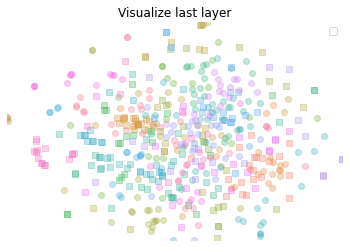

[ Test | 085/150 ] loss = 2.80830, acc = 0.52344
[Time cost | 085/150]: 863.3583s
Epoch:  85
[ Train | 086/150 ] loss = 0.14031, acc = 0.95777
squeezing data
visualizing


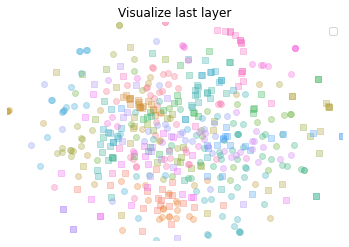

[ Test | 086/150 ] loss = 2.82822, acc = 0.51893
[Time cost | 086/150]: 1385.8358s
Epoch:  86
[ Train | 087/150 ] loss = 0.15339, acc = 0.95396
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

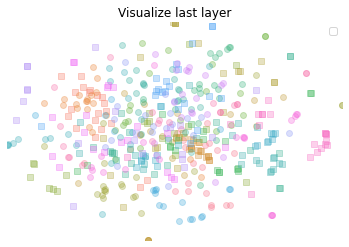

[ Test | 087/150 ] loss = 2.95468, acc = 0.52849
[Time cost | 087/150]: 1109.2468s
Epoch:  87
[ Train | 088/150 ] loss = 0.11940, acc = 0.96170
squeezing data
visualizing


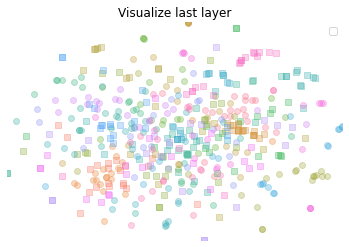

[ Test | 088/150 ] loss = 2.90282, acc = 0.53145
[Time cost | 088/150]: 1024.4290s
Epoch:  88
[ Train | 089/150 ] loss = 0.14588, acc = 0.95766
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

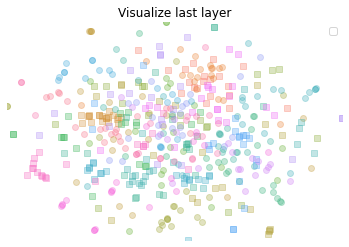

[ Test | 089/150 ] loss = 2.67927, acc = 0.53590
[Time cost | 089/150]: 1248.4015s
Epoch:  89
[ Train | 090/150 ] loss = 0.11938, acc = 0.96197
squeezing data
visualizing


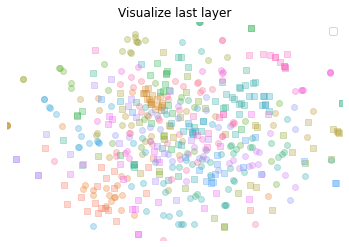

[ Test | 090/150 ] loss = 2.75908, acc = 0.52613
[Time cost | 090/150]: 1191.2125s
Epoch:  90
[ Train | 091/150 ] loss = 0.10550, acc = 0.96969
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

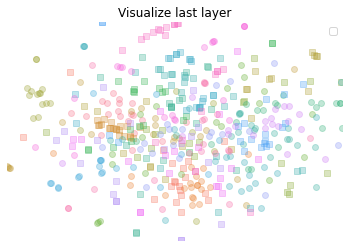

[ Test | 091/150 ] loss = 2.68416, acc = 0.52088
[Time cost | 091/150]: 877.5575s
Epoch:  91
[ Train | 092/150 ] loss = 0.11919, acc = 0.96577
squeezing data
visualizing


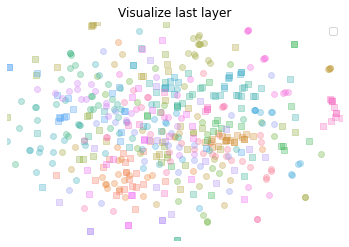

[ Test | 092/150 ] loss = 2.60939, acc = 0.53536
[Time cost | 092/150]: 978.0136s
Epoch:  92
[ Train | 093/150 ] loss = 0.10320, acc = 0.96786
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

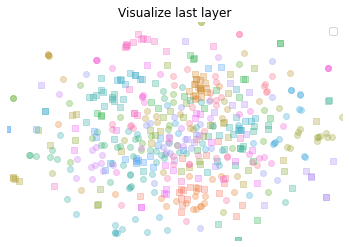

[ Test | 093/150 ] loss = 2.53078, acc = 0.55058
[Time cost | 093/150]: 904.7411s
Epoch:  93
[ Train | 094/150 ] loss = 0.12383, acc = 0.96279
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


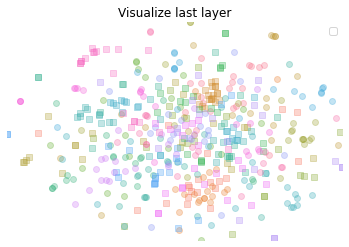

[ Test | 094/150 ] loss = 2.77535, acc = 0.52283
[Time cost | 094/150]: 1104.5756s
Epoch:  94
[ Train | 095/150 ] loss = 0.10752, acc = 0.96764
squeezing data
visualizing


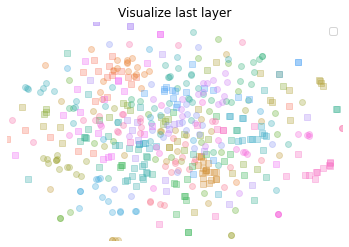

[ Test | 095/150 ] loss = 2.94779, acc = 0.52202
[Time cost | 095/150]: 1293.1985s
Epoch:  95
[ Train | 096/150 ] loss = 0.13008, acc = 0.96085
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

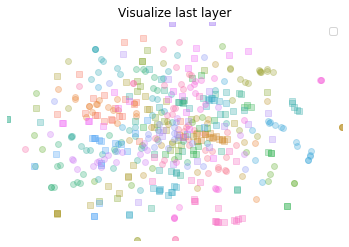

[ Test | 096/150 ] loss = 3.02688, acc = 0.50155
[Time cost | 096/150]: 1167.5133s
Epoch:  96
[ Train | 097/150 ] loss = 0.11058, acc = 0.96733
squeezing data
visualizing


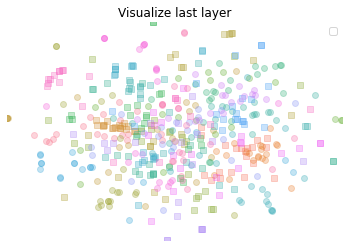

[ Test | 097/150 ] loss = 2.88435, acc = 0.51657
[Time cost | 097/150]: 1591.4228s
Epoch:  97
[ Train | 098/150 ] loss = 0.10828, acc = 0.96671
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

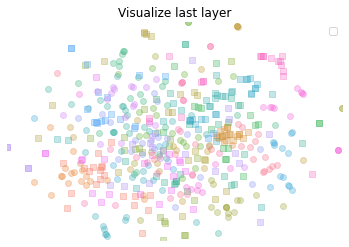

[ Test | 098/150 ] loss = 2.93715, acc = 0.52162
[Time cost | 098/150]: 1292.8759s
Epoch:  98
[ Train | 099/150 ] loss = 0.10143, acc = 0.96866
squeezing data
visualizing


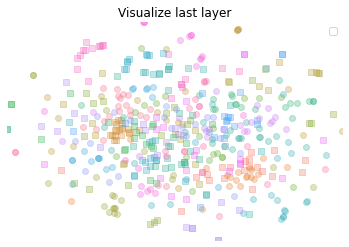

[ Test | 099/150 ] loss = 3.06544, acc = 0.52337
[Time cost | 099/150]: 1084.3861s
Epoch:  99
[ Train | 100/150 ] loss = 0.11274, acc = 0.96496
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

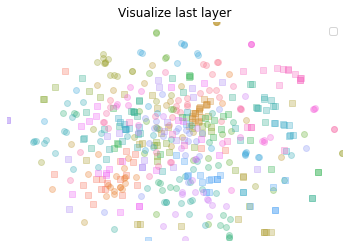

[ Test | 100/150 ] loss = 3.11184, acc = 0.51125
[Time cost | 100/150]: 891.6378s
Epoch:  100
[ Train | 101/150 ] loss = 0.11100, acc = 0.96937
squeezing data
visualizing


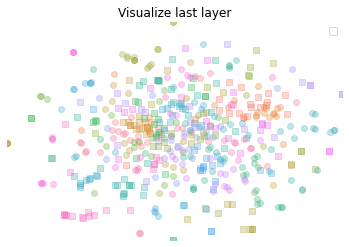

[ Test | 101/150 ] loss = 2.84139, acc = 0.53314
[Time cost | 101/150]: 891.0289s
Epoch:  101
[ Train | 102/150 ] loss = 0.08479, acc = 0.97471
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

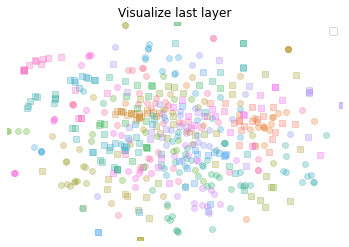

[ Test | 102/150 ] loss = 2.95778, acc = 0.54061
[Time cost | 102/150]: 841.2082s
Epoch:  102
[ Train | 103/150 ] loss = 0.10503, acc = 0.97068
squeezing data
visualizing


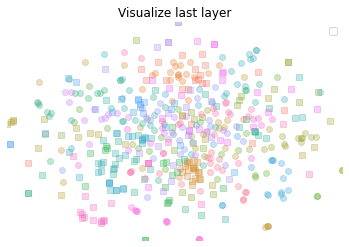

[ Test | 103/150 ] loss = 2.93912, acc = 0.53570
[Time cost | 103/150]: 885.2779s
Epoch:  103
[ Train | 104/150 ] loss = 0.19669, acc = 0.94135
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

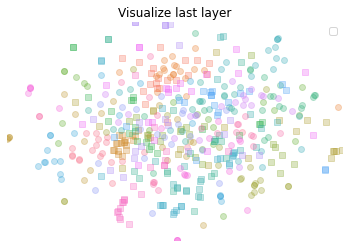

[ Test | 104/150 ] loss = 3.13223, acc = 0.50929
[Time cost | 104/150]: 892.4507s
Epoch:  104
[ Train | 105/150 ] loss = 0.18380, acc = 0.94361
squeezing data
visualizing


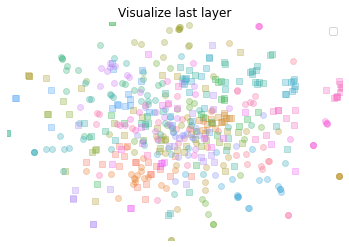

[ Test | 105/150 ] loss = 2.86192, acc = 0.50741
[Time cost | 105/150]: 1256.7877s
Epoch:  105
[ Train | 106/150 ] loss = 0.15056, acc = 0.95364
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

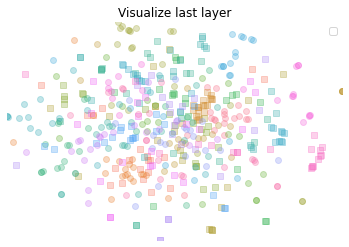

[ Test | 106/150 ] loss = 3.12576, acc = 0.49939
[Time cost | 106/150]: 1073.8166s
Epoch:  106
[ Train | 107/150 ] loss = 0.10769, acc = 0.96805
squeezing data
visualizing


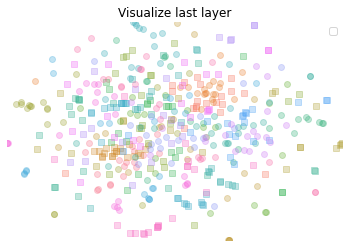

[ Test | 107/150 ] loss = 2.90692, acc = 0.52108
[Time cost | 107/150]: 1190.9023s
Epoch:  107
[ Train | 108/150 ] loss = 0.09726, acc = 0.97163
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

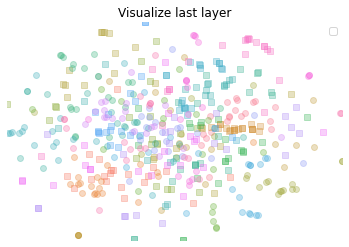

[ Test | 108/150 ] loss = 3.22249, acc = 0.51030
[Time cost | 108/150]: 820.6397s
Epoch:  108
[ Train | 109/150 ] loss = 0.08796, acc = 0.97584
squeezing data
visualizing


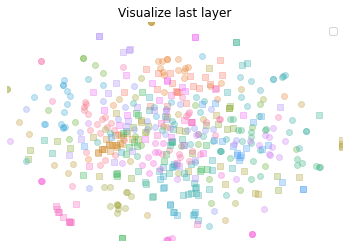

[ Test | 109/150 ] loss = 3.01675, acc = 0.51246
[Time cost | 109/150]: 792.5022s
Epoch:  109
[ Train | 110/150 ] loss = 0.08069, acc = 0.97553
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

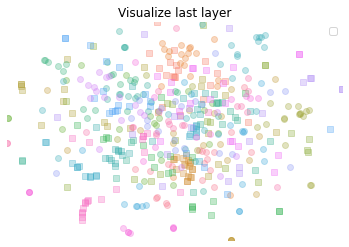

[ Test | 110/150 ] loss = 2.94775, acc = 0.51967
[Time cost | 110/150]: 835.1142s
Epoch:  110
[ Train | 111/150 ] loss = 0.08596, acc = 0.97463
squeezing data
visualizing


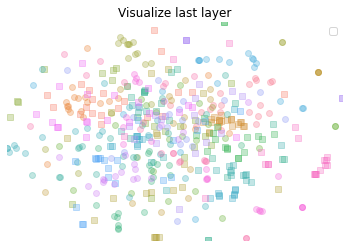

[ Test | 111/150 ] loss = 3.13581, acc = 0.51852
[Time cost | 111/150]: 830.1350s
Epoch:  111
[ Train | 112/150 ] loss = 0.08993, acc = 0.97185
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

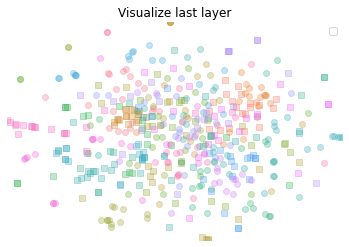

[ Test | 112/150 ] loss = 2.95723, acc = 0.52519
[Time cost | 112/150]: 839.8610s
Epoch:  112
[ Train | 113/150 ] loss = 0.09844, acc = 0.96919
squeezing data
visualizing


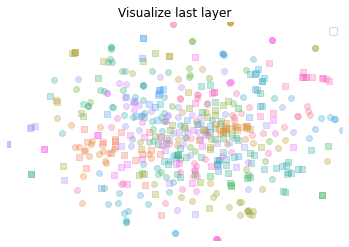

[ Test | 113/150 ] loss = 3.20381, acc = 0.51010
[Time cost | 113/150]: 852.7289s
Epoch:  113
[ Train | 114/150 ] loss = 0.09902, acc = 0.97019
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

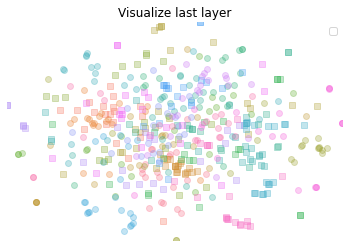

[ Test | 114/150 ] loss = 3.17497, acc = 0.50229
[Time cost | 114/150]: 879.3201s
Epoch:  114
[ Train | 115/150 ] loss = 0.09142, acc = 0.97238
squeezing data
visualizing


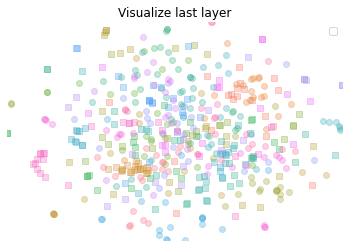

[ Test | 115/150 ] loss = 3.13341, acc = 0.51152
[Time cost | 115/150]: 894.7449s
Epoch:  115
[ Train | 116/150 ] loss = 0.11690, acc = 0.96395
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

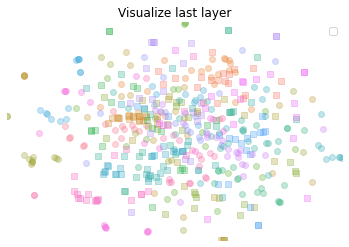

[ Test | 116/150 ] loss = 3.20704, acc = 0.50114
[Time cost | 116/150]: 819.7794s
Epoch:  116
[ Train | 117/150 ] loss = 0.12618, acc = 0.95913
squeezing data
visualizing


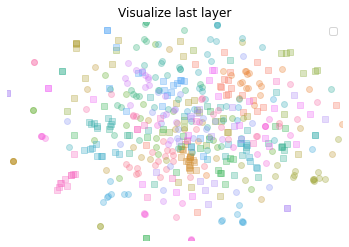

[ Test | 117/150 ] loss = 3.06112, acc = 0.50505
[Time cost | 117/150]: 786.2930s
Epoch:  117
[ Train | 118/150 ] loss = 0.12087, acc = 0.96495
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

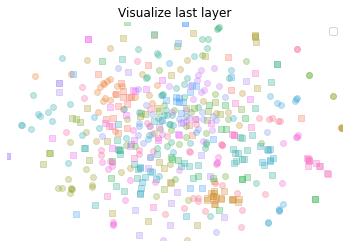

[ Test | 118/150 ] loss = 2.99265, acc = 0.51307
[Time cost | 118/150]: 794.8109s
Epoch:  118
[ Train | 119/150 ] loss = 0.09342, acc = 0.97022
squeezing data
visualizing


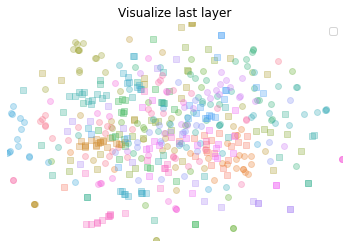

[ Test | 119/150 ] loss = 2.86544, acc = 0.52478
[Time cost | 119/150]: 818.5466s
Epoch:  119
[ Train | 120/150 ] loss = 0.10659, acc = 0.96896
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

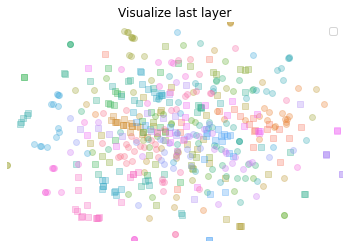

[ Test | 120/150 ] loss = 2.89712, acc = 0.50620
[Time cost | 120/150]: 883.2299s
Epoch:  120
[ Train | 121/150 ] loss = 0.11244, acc = 0.96631
squeezing data
visualizing


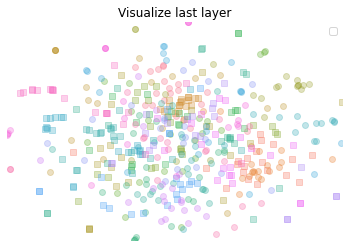

[ Test | 121/150 ] loss = 3.22420, acc = 0.48182
[Time cost | 121/150]: 860.0616s
Epoch:  121
[ Train | 122/150 ] loss = 0.11381, acc = 0.96669
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

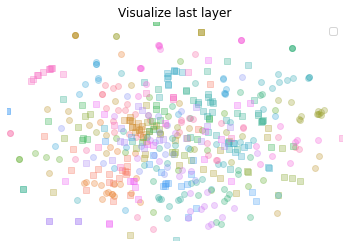

[ Test | 122/150 ] loss = 3.27862, acc = 0.49704
[Time cost | 122/150]: 819.1610s
Epoch:  122
[ Train | 123/150 ] loss = 0.07984, acc = 0.97625
squeezing data
visualizing


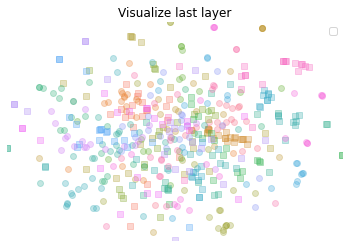

[ Test | 123/150 ] loss = 3.07041, acc = 0.52458
[Time cost | 123/150]: 945.0600s
Epoch:  123
[ Train | 124/150 ] loss = 0.08258, acc = 0.97523
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

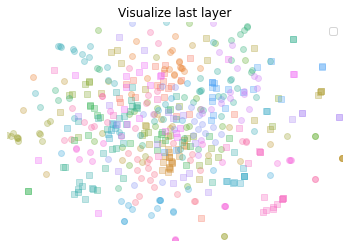

[ Test | 124/150 ] loss = 3.10522, acc = 0.53085
[Time cost | 124/150]: 860.2397s
Epoch:  124
[ Train | 125/150 ] loss = 0.08321, acc = 0.97564
squeezing data
visualizing


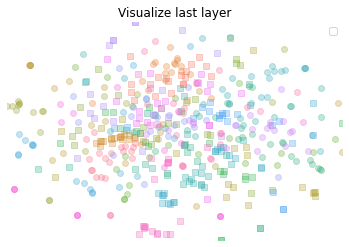

[ Test | 125/150 ] loss = 2.93933, acc = 0.52068
[Time cost | 125/150]: 805.0674s
Epoch:  125
[ Train | 126/150 ] loss = 0.08443, acc = 0.97413
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

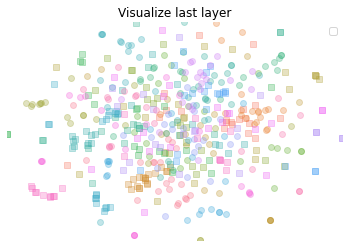

[ Test | 126/150 ] loss = 3.09138, acc = 0.50801
[Time cost | 126/150]: 775.1435s
Epoch:  126
[ Train | 127/150 ] loss = 0.11619, acc = 0.96423
squeezing data
visualizing


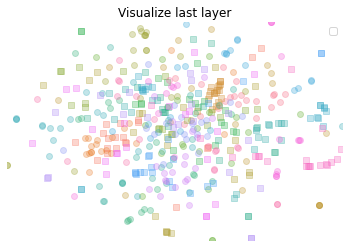

[ Test | 127/150 ] loss = 3.33910, acc = 0.52889
[Time cost | 127/150]: 820.5920s
Epoch:  127
[ Train | 128/150 ] loss = 0.09246, acc = 0.97021
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

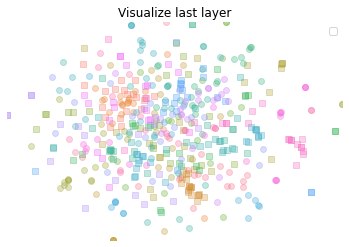

[ Test | 128/150 ] loss = 3.18915, acc = 0.49273
[Time cost | 128/150]: 864.3619s
Epoch:  128
[ Train | 129/150 ] loss = 0.10583, acc = 0.96921
squeezing data
visualizing


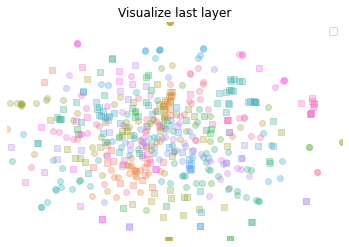

[ Test | 129/150 ] loss = 3.25232, acc = 0.48081
[Time cost | 129/150]: 891.8898s
Epoch:  129
[ Train | 130/150 ] loss = 0.12499, acc = 0.96126
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

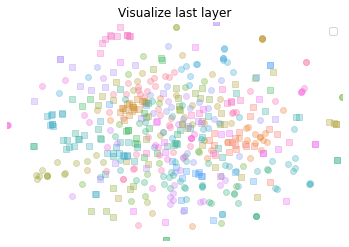

[ Test | 130/150 ] loss = 3.02987, acc = 0.50034
[Time cost | 130/150]: 836.4170s
Epoch:  130
[ Train | 131/150 ] loss = 0.11816, acc = 0.96270
squeezing data
visualizing


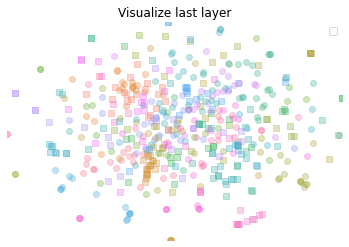

[ Test | 131/150 ] loss = 3.18868, acc = 0.48512
[Time cost | 131/150]: 810.2942s
Epoch:  131
[ Train | 132/150 ] loss = 0.09025, acc = 0.97164
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

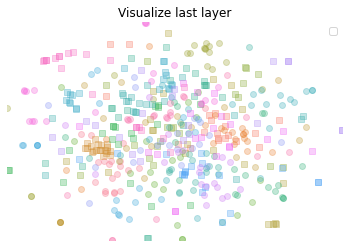

[ Test | 132/150 ] loss = 2.91330, acc = 0.48882
[Time cost | 132/150]: 949.8220s
Epoch:  132
[ Train | 133/150 ] loss = 0.10500, acc = 0.96806
squeezing data
visualizing


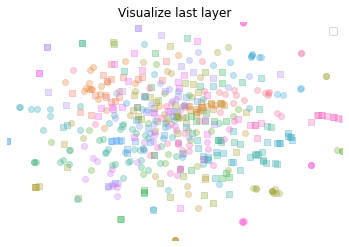

[ Test | 133/150 ] loss = 2.94986, acc = 0.52364
[Time cost | 133/150]: 886.0552s
Epoch:  133
[ Train | 134/150 ] loss = 0.11621, acc = 0.96414
squeezing data
visualizing


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

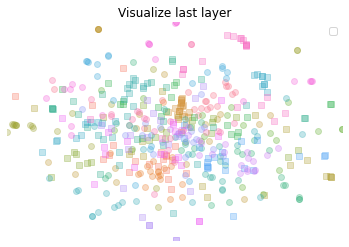

[ Test | 134/150 ] loss = 3.02319, acc = 0.51596
[Time cost | 134/150]: 1002.2550s
Epoch:  134
[ Train | 136/150 ] loss = 0.08780, acc = 0.97255
squeezing data
visualizing


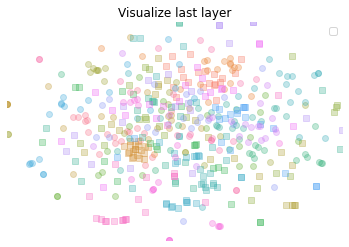

[ Test | 136/150 ] loss = 2.72431, acc = 0.53320
[Time cost | 136/150]: 1023.6971s
Epoch:  136


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with lab

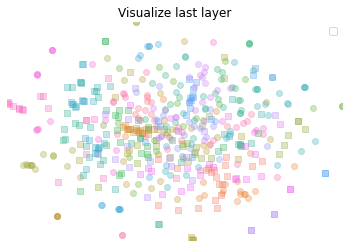

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No handles with labels found to put in legend.


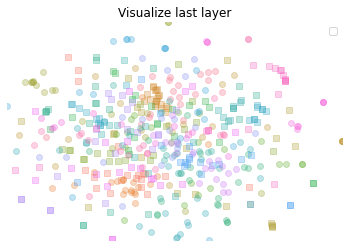

In [7]:
# Train for 20 times rounds
n_epochs = 150
best_acc = 0.0
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    start_time = time.time()

    cnn.train()

    train_loss = []
    train_acc = []

    for batch in train_loader:
        data, labels = batch

        predict, _ = cnn(data.to(device))
        loss = cross_entropy(predict, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # acc = torch.tensor(predict.argmax(dim=-1) == labels.to(device)).float().mean()
        acc = (predict.argmax(dim=-1) == labels.to(device).clone().detach()).float().mean()
        train_loss.append(loss.item())
        train_acc.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_acc) / len(train_acc)
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    cnn.eval()

    test_loss = []
    test_acc = []
    visual_label_set = []
    visual_predict_set = []
    for batch in test_loader:
        data, labels = batch

        with torch.no_grad():
            predict, last_layer_item = cnn(data.to(device))

        loss = cross_entropy(predict, labels.to(device))

        # acc = torch.tensor(predict.argmax(dim=-1) == labels.to(device)).float().mean()
        acc = (predict.argmax(dim=-1) == labels.to(device).clone().detach()).float().mean()

        test_loss.append(loss.item())
        test_acc.append(acc)
        visual_predict_set.append(last_layer_item)
        visual_label_set.append(labels.to(device).unsqueeze(-1))
    print("squeezing data")
    v_last_layer_item = torch.vstack(visual_predict_set)
    v_labels = torch.vstack(visual_label_set)

    if epoch % 10 ==0:
        print("visualizing")
        # Visualization of trained flatten layer (T-SNE)
        tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
        low_dim_embs = tsne.fit_transform(v_last_layer_item.data.numpy()[:, :])
        labels = v_labels.to(device).numpy()[:]
        plot_with_labels(low_dim_embs, labels)

    valid_loss = sum(test_loss) / len(test_loss)
    valid_acc = sum(test_acc) / len(test_acc)

    print(f"[ Test | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        best_acc = valid_acc

    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc)
    valid_acc_record.append(valid_acc)

    end_time = time.time()

    print(f"[Time cost | {epoch + 1:03d}/{n_epochs:03d}]:{end_time - start_time: .4f}s")

    if epoch % 5 == 0:
        save_model()